# **RNN과 어텐션을 사용한 자연어 처리**

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import os
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

## **Char-RNN을 사용해 셰익스피어 문제 생성하기**

예를 들어, 0~14까지 시퀀스를 2개씩 이동하면서 길이가 5인 윈도우로 나누어 본다(가령,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, 등). 그다음 이를 섞고 입력(처음 네 개의 스텝)과 타깃(마지막 네 개의 스텝)으로 나눈다(즉, `[2, 3, 4, 5, 6]`를 `[[2, 3, 4, 5], [3, 4, 5, 6]]`로 나눈다). 그다음 입력/타깃 쌍 세 개로 구성된 배치를 만든다:

In [2]:
import tensorflow as tf

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, 2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(tf.data.AUTOTUNE)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print(f'{"_" * 20} Batch {index}\nX_batch\n{X_batch.numpy()}\n{"=" * 5}\nY_batch\n{Y_batch.numpy()}')

____________________ Batch 0
X_batch
[[4 5 6 7]
 [0 1 2 3]
 [2 3 4 5]]
=====
Y_batch
[[5 6 7 8]
 [1 2 3 4]
 [3 4 5 6]]
____________________ Batch 1
X_batch
[[ 6  7  8  9]
 [ 8  9 10 11]
 [10 11 12 13]]
=====
Y_batch
[[ 7  8  9 10]
 [ 9 10 11 12]
 [11 12 13 14]]


### **훈련 데이터셋 만들기**

In [3]:
from tensorflow import keras

shakespeare_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
filepath = keras.utils.get_file('shakespeare.txt', shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
''.join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [7]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [8]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [9]:
max_id = len(tokenizer.word_index)  # 고유한 문자 개수
dataset_size = tokenizer.document_count  # 전체 문자 개수

In [10]:
import numpy as np

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

### **순차 데이터셋을 나누는 방법**

In [11]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### **순차 데이터를 윈도 여러 개로 자르기**

In [12]:
n_steps = 100
window_length = n_steps + 1  # 타깃 = 한 글자 앞선 입력
dataset = dataset.window(window_length, 1, drop_remainder=True)

In [13]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [14]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, max_id), Y_batch))

In [16]:
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [17]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### **Char-RNN 모델 만들고 훈련하기**

**경고**: 다음 코드는 하드웨어에 따라 실행하는데 24시간이 걸릴 수 있다. GPU를 사용하면 1~2시간 정도 걸릴 수 있다.

**노트**: `GRU` 클래스는 다음 매개변수에서 기본값을 사용할 때에만 GPU를 사용한다: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` `reset_after`. 이 때문에 `recurrent_dropout=0.2`를 주석 처리했다.

In [18]:
model = keras.Sequential(
    [
        keras.layers.GRU(128, dropout=0.2, return_sequences=True, input_shape=[None, max_id]),  # recurrent_dropout=0.2
        keras.layers.GRU(128, dropout=0.2, return_sequences=True),  # recurrent_dropout=0.2
        keras.layers.TimeDistributed(keras.layers.Dense(max_id, 'softmax'))
    ]
)
model.compile('adam', 'sparse_categorical_crossentropy')
# history = model.fit(dataset, epochs=10)
history = model.fit(dataset.take(2142))

2142/2142 [==============================] - 75s 28ms/step - loss: 1.9490


### **Char-RNN 모델 사용하기**

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [20]:
X_new = preprocess(['How are yo'])
Y_pred = np.argmax(model(X_new), -1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]  # 첫 번째 문장, 마지막 문자

'u'

### **가짜 셰익스피어 텍스트를 생성하기**

In [21]:
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], 40).numpy()

array([[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1, 1,
        1, 2, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 2]],
      dtype=int64)

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, 1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
next_char('How are yo')

'u'

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [25]:
print(complete_text('t', temperature=0.2))

t the corn and the people, the consul, the corsel t


In [26]:
print(complete_text('t'))

ter, but think dis fire? this is riburn ind folsces


In [27]:
print(complete_text('t', temperature=2))

tegse spiri.
hc't.! trann! my
ds,ralwc

teich' , ub


### **상태가 있는 RNN**

In [28]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, max_id), Y_batch))
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [29]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, max_id), Y_batch))
dataset = dataset.prefetch(tf.data.AUTOTUNE)

**노트**: 여기에서도 GPU 가속을 위해 `recurrent_dropout=0.2`을 주석 처리한다.

In [30]:
model = keras.Sequential(
    [
        keras.layers.GRU(
            128, dropout=0.2, return_sequences=True, stateful=True, batch_input_shape=[batch_size, None, max_id]
        ),  # recurrent_dropout=0.2
        keras.layers.GRU(128, dropout=0.2, return_sequences=True, stateful=True),  # recurrent_dropout=0.2
        keras.layers.TimeDistributed(keras.layers.Dense(max_id, 'softmax'))
    ]
)

In [31]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [32]:
model.compile('adam', 'sparse_categorical_crossentropy')
# history = model.fit(dataset, epochs=50, callbacks=[ResetStatesCallback()])
history = model.fit(dataset, epochs=7, callbacks=[ResetStatesCallback()])

Epoch 1/7
313/313 [==============================] - 10s 26ms/step - loss: 2.6247
Epoch 2/7
313/313 [==============================] - 8s 26ms/step - loss: 2.2471
Epoch 3/7
313/313 [==============================] - 8s 26ms/step - loss: 2.1134
Epoch 4/7
313/313 [==============================] - 8s 26ms/step - loss: 2.0371
Epoch 5/7
313/313 [==============================] - 8s 26ms/step - loss: 1.9850
Epoch 6/7
313/313 [==============================] - 8s 26ms/step - loss: 1.9481
Epoch 7/7
313/313 [==============================] - 8s 26ms/step - loss: 1.9202


모델에 다른 크기의 배치를 사용하려면 상태가 없는 복사본을 만들어야 한다. 드롭아웃은 훈련에만 사용되기 때문에 삭제한다:

In [33]:
stateless_model = keras.Sequential(
    [
        keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(max_id, 'softmax'))
    ]
)

가중치를 복사하려면 먼저 (가중치를 만들기 위해) 모델을 빌드한다:

In [34]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [35]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [36]:
print(complete_text('t'))

t.
well, i was stose by and thou patisury
his nastl


## **감성 분석**

In [37]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

In [38]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [39]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(('<pad>', '<sos>', '<unk>')):
    id_to_word[id_] = token
' '.join([id_to_word[id_] for id_ in X_train[0][:10]])

'<sos> this film was just brilliant casting location scenery story'

In [40]:
import tensorflow_datasets as tfds

datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)

In [41]:
datasets.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [42]:
train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples

In [43]:
train_size, test_size

(25000, 25000)

In [44]:
for X_batch, y_batch in datasets['train'].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print(f'Review: {review.decode("utf-8")[:200]}...\nLabel: {label} = {"Positive" if label else "Negative"}\n')

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ...
Label: 0 = Negative



In [45]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b'<br\s*/?>', b' ')
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b' ')
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(b'<pad>'), y_batch

In [46]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [47]:
from collections import Counter

vocabulary = Counter()
for X_batch, _ in datasets['train'].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [48]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [49]:
len(vocabulary)

53893

In [50]:
vocab_size = 10000
truncated_vocabulary = [word for word, _ in vocabulary.most_common()[:vocab_size]]

In [51]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b'This movie was faaaaaantastic'.split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [52]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [53]:
table.lookup(tf.constant([b'This movie was faaaaaantastic'.split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

In [54]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch


train_set = datasets['train'].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(tf.data.AUTOTUNE)

In [55]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [56]:
embed_size = 128
model = keras.Sequential(
    [
        keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, mask_zero=True, input_shape=[None]),
        keras.layers.GRU(128, return_sequences=True),
        keras.layers.GRU(128),
        keras.layers.Dense(1, 'sigmoid')
    ]
)
model.compile('adam', 'binary_crossentropy', ['accuracy'])
# history = model.fit(train_set, epochs=5)
history = model.fit(train_set, epochs=2)

Epoch 1/2
782/782 [==============================] - 26s 24ms/step - loss: 0.5382 - accuracy: 0.7220
Epoch 2/2
782/782 [==============================] - 19s 24ms/step - loss: 0.3475 - accuracy: 0.8554


### **마스킹**

In [57]:
K = keras.backend
embed_size = 128
inputs = keras.Input([None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, 'sigmoid')(z)
model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile('adam', 'binary_crossentropy', ['accuracy'])
# history = model.fit(train_set, epochs=5)
history = model.fit(train_set, epochs=2)

Epoch 1/2
782/782 [==============================] - 26s 25ms/step - loss: 0.5389 - accuracy: 0.7235
Epoch 2/2
782/782 [==============================] - 19s 25ms/step - loss: 0.3492 - accuracy: 0.8559


### **사전훈련된 임베딩 재사용하기**

In [58]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, 'my_tfhub_cache')
os.environ['TFHUB_CACHE_DIR'] = TFHUB_CACHE_DIR

In [59]:
import tensorflow_hub as hub

model = keras.Sequential(
    [
        hub.KerasLayer(
            'https://tfhub.dev/google/nnlm-en-dim50/2', output_shape=[50], input_shape=[], dtype=tf.string
        ),
        keras.layers.Dense(128, 'relu'),
        keras.layers.Dense(1, 'sigmoid')
    ]
)
model.compile('adam', 'binary_crossentropy', ['accuracy'])

In [60]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

.\my_tfhub_cache\74a841d6eb84e8d93d913d716fb5440d020cc291.descriptor.txt
.\my_tfhub_cache\74a841d6eb84e8d93d913d716fb5440d020cc291\saved_model.pb
.\my_tfhub_cache\74a841d6eb84e8d93d913d716fb5440d020cc291\assets\tokens.txt
.\my_tfhub_cache\74a841d6eb84e8d93d913d716fb5440d020cc291\variables\variables.data-00000-of-00001
.\my_tfhub_cache\74a841d6eb84e8d93d913d716fb5440d020cc291\variables\variables.index


In [61]:
datasets, info = tfds.load('imdb_reviews', as_supervised=True, with_info=True)
train_size = info.splits['train'].num_examples
batch_size = 32
train_set = datasets['train'].batch(batch_size).prefetch(tf.data.AUTOTUNE)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5510 - accuracy: 0.7203
Epoch 2/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5144 - accuracy: 0.7481
Epoch 3/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5091 - accuracy: 0.7518
Epoch 4/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5053 - accuracy: 0.7547
Epoch 5/5
782/782 [==============================] - 5s 6ms/step - loss: 0.5022 - accuracy: 0.7574


## **신경망 기계 번역을 위한 인코더-디코더 네트워크**

In [62]:
vocab_size = 100
embed_size = 10

In [63]:
import tensorflow_addons as tfa

encoder_inputs = keras.Input([None], dtype=np.int32)
decoder_inputs = keras.Input([None], dtype=np.int32)
sequence_lengths = keras.Input([], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]
sampler = tfa.seq2seq.TrainingSampler()
decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.BasicDecoder(decoder_cell, sampler, output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state, sequence_length=sequence_lengths
)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)
model = keras.Model(inputs=[encoder_inputs, decoder_inputs, sequence_lengths], outputs=[Y_proba])

In [64]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [65]:
X = np.random.randint(100, size=10 * 1000).reshape(1000, 10)
Y = np.random.randint(100, size=15 * 1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)
history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 5s 65ms/step - loss: 4.6054
Epoch 2/2
32/32 [==============================] - 2s 66ms/step - loss: 4.6035


### **양방향 RNN**

In [66]:
model = keras.Sequential(
    [
        keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
        keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, None, 10)          660       
                                                                 
 bidirectional (Bidirectiona  (None, None, 20)         1320      
 l)                                                              
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


## **어텐션 메커니즘**

### **트랜스포머 구조: 어텐션이 필요한 전부다**

**위치 인코딩**

In [67]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1  # max_dims는 짝수여야 한다.
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000 ** (2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000 ** (2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))

    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [68]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

그림 저장 positional_embedding_plot


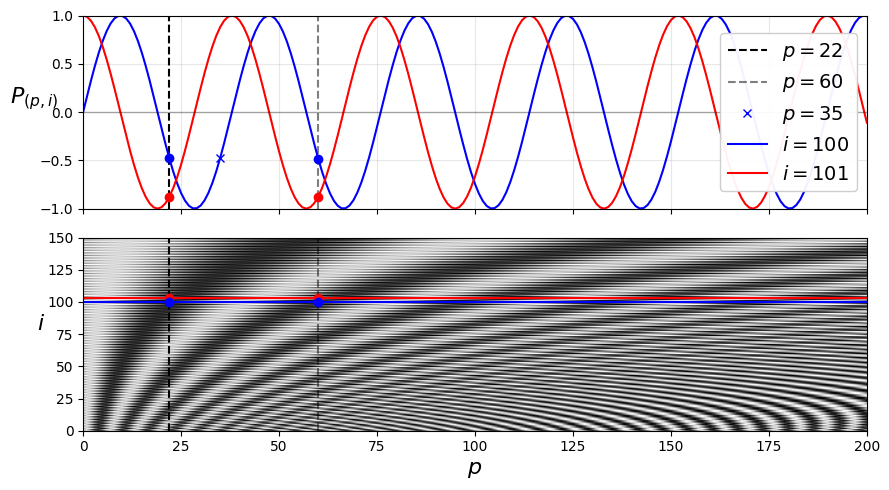

In [69]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], 'k--', label=f'$p = {p1}$')
ax1.plot([p2, p2], [-1, 1], 'k--', label=f'$p = {p2}$', alpha=0.5)
ax1.plot(p3, PE[p3, i1], 'bx', label=f'$p = {p3}$')
ax1.plot(PE[:, i1], 'b-', label=f'$i = {i1}$')
ax1.plot(PE[:, i2], 'r-', label=f'$i = {i2}$')
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], 'bo')
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], 'ro')
ax1.legend(loc='center right', fontsize=14, framealpha=0.95)
ax1.set_ylabel('$P_{(p,i)}$', rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color='k', linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], 'gray', aspect='auto', interpolation='bilinear')
ax2.hlines(i1, 0, max_steps - 1, color='b')
cheat = 2  # 빨간색 선을 약간 올려야 한다. 그렇지 않으면 파란색 선이 숨겨진다.
ax2.hlines(i2 + cheat, 0, max_steps - 1, color='r')
ax2.plot([p1, p1], [0, crop_i], 'k--')
ax2.plot([p2, p2], [0, crop_i], 'k--', alpha=0.5)
ax2.plot([p1, p2], [i2 + cheat, i2 + cheat], 'ro')
ax2.plot([p1, p2], [i1, i1], 'bo')
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel('$p$', fontsize=16)
ax2.set_ylabel('$i$', rotation=0, fontsize=16)
save_fig('positional_embedding_plot')
plt.show()

In [70]:
embed_size = 512
max_steps = 500
vocab_size = 10000
encoder_inputs = keras.Input([None], dtype=np.int32)
decoder_inputs = keras.Input([None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

**멀티-헤드 어텐션**

다음은 (매우) 간소화한 Transformer이다(실제 구조는 스킵 연결, 층 정규화, 밀집 층 그리고 가장 중요하게 일반적인 어텐션이 아니라 멀티-헤드 어텐션을 가진다):

In [71]:
Z = encoder_in
for _ in range(6):
    Z = keras.layers.Attention(True)([Z, Z])
encoder_outputs = Z
Z = decoder_in
for _ in range(6):
    Z = keras.layers.Attention(True)([Z, Z], use_causal_mask=True)
    Z = keras.layers.Attention(True)([Z, encoder_outputs])
outputs = keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, 'softmax'))(Z)

다음은 기본적인 `MultiHeadAttention` 층의 구현이다. `kernel_size=1`인 (그리고 기본값 `padding='valid'`, `strides=1`을 사용하는) `Conv1D` 층은 `TimeDistributed(Dense(...))`과 같다.

In [72]:
K = keras.backend


class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, use_scale=False, **kwargs):
        self.dims = self.q_dims = self.v_dims = self.k_dims = self.q_linear = self.v_linear = self.k_linear = self. \
            attention = self.out_linear = None
        self.n_heads = n_heads
        self.use_scale = use_scale
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3  # 대신 하이퍼파라미터가 될 수 있다.
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, 1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, 1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, 1, use_bias=False)
        self.attention = keras.layers.Attention(use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, 1, use_bias=False)
        super().build(batch_input_shape)

    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])

    def call(self, inputs, use_causal_mask=False):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj], use_causal_mask=use_causal_mask)
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [73]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape
# multi_attn = keras.layers.MultiHeadAttention(8, 64)
# multi_attn(Q, V).shape

TensorShape([2, 50, 512])

## **연습**

### **1.**

호크라이터와 슈미트후버는 LSTM에 관한 [논문](https://scholar.google.com/scholar?q=Long+Short-Term+Memory+author%3ASchmidhuber)에서 임베딩된 레버 문법을 사용했다. 이는 ‘BPBTSXXVPSEPE’와 같은 문자열을 만드는 인공 문법이다. 이 주제에 대한 제니 오어의 훌륭한 [소개](https://www.willamette.edu/~gorr/classes/cs449/reber.html)를 확인한다. 특정 임베딩된 레버 문법 하나를 선택하고(제니 오어의 페이지에 있는 것과 같은), 그다음에 문자열이 이 문법을 따르는지 아닌지 구별하는 RNN을 훈련한다. 먼저 문법에 맞는 문자열 50%와 그렇지 않은 문자열 50%를 담은 훈련 배치를 생성하는 함수를 만든다.

먼저 문법에 맞는 문자열을 생성하는 함수가 필요하다. 이 문법은 각 상태에서 가능한 전이 상태의 리스트이다. 하나의 전이는 출력할 문자열(또는 생성할 문법)과 다음 상태를 지정한다.

In [74]:
default_reber_grammar = [
    [('B', 1)],
    [('T', 2), ('P', 3)],
    [('S', 2), ('X', 4)],
    [('T', 3), ('V', 5)],
    [('X', 3), ('S', 6)],
    [('P', 4), ('V', 6)],
    [('E', None)]
]

embedded_reber_grammar = [
    [('B', 1)],
    [('T', 2), ('P', 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [('T', 6)],
    [('P', 6)],
    [('E', None)]
]


def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(production)
        output.append(production)
    return ''.join(output)

기본 레버 문법에 맞는 문자열을 몇 개 만든다:

In [75]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=' ')

BTXXVPXVPSE BTSSXXTVPSE BPTTVPSE BPTTTVPSE BPTVPSE BTXXVPSE BTSXXVVE BTXSE BPVPXTVVE BTXSE BTXSE BTSXSE BTXSE BTSXSE BPVVE BPVPXVVE BPTVPXTVVE BPTVVE BPTTVVE BPVPXVPSE BPTVPXVPXTVPSE BTXXVPSE BTXSE BTXXTTTVPXTVVE BPVPSE 

이제 임베딩된 레버 문법에 맞는 문자열을 몇 개 만든다:

In [76]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=' ')

BPBPVPSEPE BTBTXSETE BPBPVPSEPE BTBPVVETE BPBPVVEPE BPBPVVEPE BTBPVPXVVETE BPBPVPSEPE BTBPVPXTTTVPXTVVETE BTBTSSXXTVVETE BPBPVPXTVVEPE BTBTXXVVETE BPBPVVEPE BTBTSXXTTTVVETE BTBPTVPSETE BPBTSXSEPE BPBPVPXTVPSEPE BTBPVVETE BTBTXSETE BPBPVVEPE BTBTXSETE BTBPVPSETE BPBTSXXTTTVVEPE BTBPTTVPSETE BPBTXSEPE 

이제 이 문법을 따르지 않는 문자열을 생성할 함수를 만든다. 무작위하게 문자열을 만들 수 있지만 그렇게 하면 너무 문제가 쉬워지므로 대신 문법을 따르는 문자열을 만든 후 하나의 문자만 바꾼다:

In [77]:
POSSIBLE_CHARS = 'BEPSTVX'


def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

잘못된 문자열 몇 개를 만든다:

In [78]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=' ')

BTBTSXXVBXVPSETE BTBTXXTVXSETE BPBTXSTVPSEPE BTBTXXTTVPSETB BTXTSXXVVETE BPBTXXTVVSPE BTEPVPXVVETE BTBTSXSEPE BTBPVVETB BBBTXSETE BVBPVVEPE BTBESXSETE BTBPXTTVPXTTVPSETE BTBPTVPXTVPSBTE BTBTXXVVXTE VTBPVVETE BTBPVVEEE BTBPVPXTVPSXTE BPBBVVEPE BTBTSXXVVPTE BTXPVVETE STBPTTTTTVVETE BPBSSSSSXSEPE TPBPVPSEPE BTBPVVEBE 

문자열을 바로 RNN에 주입할 수는 없기 때문에 어떤 식으로든 인코딩해야 한다. 한 가지 방법은 각 문자를 원-핫 인코딩하는 것이다. 또 다른 방식은 임베딩을 사용하는 것이다. 두 번째 방법을 사용해 본다(문자 개수가 작다면 원-핫 인코딩도 좋은 선택이다). 임베딩을 위해 각 문자열을 문자 ID의 시퀀스로 바꾼다. POSSIBLE_CHARS의 문자열 인덱스를 사용해 이런 작업을 수행하는 함수를 만든다:

In [79]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [80]:
string_to_ids('BTTTXXVVETE')

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

이제 50%는 올바른 문자열 50%는 잘못된 문자열로 이루어진 데이터셋을 만든다:

In [81]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar)) for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar)) for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] + [[0.] for _ in range(len(bad_strings))])
    return X, y

In [82]:
X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

첫 번째 훈련 샘플을 확인해 본다:

In [83]:
X_train[0]

<tf.Tensor: shape=(19,), dtype=int32, numpy=array([0, 2, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 2, 3, 1, 2, 1])>

어떤 클래스에 속할까?

In [84]:
y_train[0]

array([1.])

이제 올바른 문자열을 구분할 RNN을 만들 준비가 되었다. 간단한 시퀀스 이진 분류기를 만든다:

In [85]:
embedding_size = 5
model = keras.Sequential(
    [
        keras.layers.InputLayer([None], dtype=tf.int32, ragged=True),
        keras.layers.Embedding(len(POSSIBLE_CHARS), embedding_size),
        keras.layers.GRU(30),
        keras.layers.Dense(1, 'sigmoid')
    ]
)
optimizer = keras.optimizers.legacy.SGD(0.02, 0.95, True)
model.compile(optimizer, 'binary_crossentropy', ['accuracy'])
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, epochs=17, validation_data=(X_valid, y_valid))

Epoch 1/17


C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/gru_12/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


313/313 [==============================] - 5s 12ms/step - loss: 0.6936 - accuracy: 0.4995 - val_loss: 0.6880 - val_accuracy: 0.5410
Epoch 2/17
313/313 [==============================] - 3s 10ms/step - loss: 0.6740 - accuracy: 0.5542 - val_loss: 0.6731 - val_accuracy: 0.5890
Epoch 3/17
313/313 [==============================] - 3s 10ms/step - loss: 0.6528 - accuracy: 0.5770 - val_loss: 0.6529 - val_accuracy: 0.6140
Epoch 4/17
313/313 [==============================] - 3s 10ms/step - loss: 0.6387 - accuracy: 0.5887 - val_loss: 0.6252 - val_accuracy: 0.6425
Epoch 5/17
313/313 [==============================] - 3s 10ms/step - loss: 0.6035 - accuracy: 0.6413 - val_loss: 0.5745 - val_accuracy: 0.6590
Epoch 6/17
313/313 [==============================] - 3s 10ms/step - loss: 0.5177 - accuracy: 0.7273 - val_loss: 0.4152 - val_accuracy: 0.8170
Epoch 7/17
313/313 [==============================] - 3s 10ms/step - loss: 0.3079 - accuracy: 0.8785 - val_loss: 0.2172 - val_accuracy: 0.9270
Epoch 8/17

이제 두 개의 까다로운 문자열로 이 RNN을 테스트해 본다: 첫 번째는 잘못된 것이고 두 번째는 올바른 것이다. 이 문자열은 마지막에서 두 번째 글자만 다룬다. RNN이 이를 맞춘다면 두 번째 문자가 항상 끝에서 두 번째 문자와 같아야 한다는 패턴을 알게 됐다는 것을 의미한다. 이렇게 하려면 꽤 긴 단기 기억(long short-term memory)이 필요하다(그래서 GRU 셀을 사용했다).

In [86]:
test_strings = ['BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE', 'BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE']
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)
y_proba = model.predict(X_test)
print('\n레버 문자열일 추정 확률:')
for index, string in enumerate(test_strings):
    print(f'{string}: {100 * y_proba[index][0]:.2f}%')

1/1 [==============================] - 0s 318ms/step

레버 문자열일 추정 확률:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.76%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.92%


잘 작동한다. 이 RNN이 높은 신뢰도로 정확한 답을 냈다.

### **2.**

날짜 문자열 포맷을 변환하는 인코더-디코더 모델을 훈련한다(예를 들어, ‘April 22, 2019’에서 ‘2019-04-22’로 바꾼다).

먼저 데이터셋을 만든다. 1000-01-01 ~ 9999-12-31 사이의 랜덤한 날짜를 사용하겠다:

In [87]:
from datetime import date

# strftime()의 %B 포맷은 로케일에 의존하기 때문에 사용할 수 없다.
MONTHS = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December'
]


def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()
    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]
    x = [f'{MONTHS[dt.month - 1]}  {dt.strftime("%d, %Y")}' for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [88]:
n_dates = 3
x_example, y_example = random_dates(n_dates)
print(f'{"Input":25s}{"Target":25s}\n{"-" * 50}')
for x, y in zip(x_example, y_example):
    print(f'{x:25s}{y:25s}')

Input                    Target                   
--------------------------------------------------
April  23, 4616          4616-04-23               
March  19, 9537          9537-03-19               
February  14, 7989       7989-02-14               


입력에 가능한 전체 문자를 나열한다:

In [89]:
INPUT_CHARS = ''.join(sorted(set(f'{"".join(MONTHS)}0123456789, ')))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

그리고 다음은 출력에 가능한 전체 문자이다:

In [90]:
OUTPUT_CHARS = '0123456789-'

이전 연습에서처럼 문자열을 문자 ID 리스트로 바꾸는 함수를 작성한다:

In [91]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [92]:
date_str_to_ids(x_example[0])

[12, 31, 32, 26, 27, 0, 0, 4, 5, 1, 0, 6, 8, 3, 8]

In [93]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[4, 6, 1, 6, 10, 0, 4, 10, 2, 3]

In [94]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor()  # 패딩 토큰 ID로 0 사용


def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x), prepare_date_strs(y, OUTPUT_CHARS)

In [95]:
X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [96]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 9,  9,  5, 10, 11,  2,  2, 11,  1, 10])>

#### **첫 번째 버전: 기본적인 seq2seq 모델**

먼저 가장 간단한 모델을 시도한다: 입력 시퀀스가 먼저 (임베딩 층 뒤에 하나의 LSTM 층으로 구성된) 인코더를 통과하여 벡터로 출력된다. 그 다음 이 벡터가 (하나의 LSTM 층 뒤에 밀집 층으로 구성된) 디코더로 들어가 벡터의 시퀀스를 출력한다. 각 벡터는 가능한 모든 출력 문자에 대한 추정 확률이다.

디코더는 시퀀스를 입력으로 기대하기 때문에 가능한 가장 긴 출력 시퀀스만큼 (인코더의 출력) 벡터를 반복한다.

In [97]:
embedding_size = 32
max_output_length = Y_train.shape[1]
encoder = keras.Sequential(
    [keras.layers.Embedding(len(INPUT_CHARS) + 1, embedding_size, input_shape=[None]), keras.layers.LSTM(128)]
)
decoder = keras.Sequential(
    [keras.layers.LSTM(128, return_sequences=True), keras.layers.Dense(len(OUTPUT_CHARS) + 1, 'softmax')]
)
model = keras.Sequential([encoder, keras.layers.RepeatVector(max_output_length), decoder])
optimizer = keras.optimizers.legacy.Nadam()
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy'])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, epochs=9, validation_data=(X_valid, Y_valid))

Epoch 1/9
313/313 [==============================] - 10s 21ms/step - loss: 1.8077 - accuracy: 0.3531 - val_loss: 1.4086 - val_accuracy: 0.4726
Epoch 2/9
313/313 [==============================] - 6s 18ms/step - loss: 1.2583 - accuracy: 0.5415 - val_loss: 1.1177 - val_accuracy: 0.6010
Epoch 3/9
313/313 [==============================] - 6s 18ms/step - loss: 1.2446 - accuracy: 0.5698 - val_loss: 0.9996 - val_accuracy: 0.6533
Epoch 4/9
313/313 [==============================] - 5s 17ms/step - loss: 0.8528 - accuracy: 0.6902 - val_loss: 0.8060 - val_accuracy: 0.6931
Epoch 5/9
313/313 [==============================] - 6s 18ms/step - loss: 0.7162 - accuracy: 0.7330 - val_loss: 0.5760 - val_accuracy: 0.7793
Epoch 6/9
313/313 [==============================] - 5s 17ms/step - loss: 0.7281 - accuracy: 0.7409 - val_loss: 0.6660 - val_accuracy: 0.7729
Epoch 7/9
313/313 [==============================] - 5s 17ms/step - loss: 0.4715 - accuracy: 0.8358 - val_loss: 0.3659 - val_accuracy: 0.8752
Epoch

100% 검증 정확도를 달성했다! 이 모델을 사용해 예측을 만든다. 문자 ID 시퀀스를 문자열로 바꾸는 함수를 작성한다:

In [98]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return [''.join([('?' + chars)[index] for index in sequence]) for sequence in ids]

이제 모델을 사용해 샘플 날짜를 변환한다.

In [99]:
X_new = prepare_date_strs(['September 17, 2009', 'July 14, 1789'])

In [100]:
ids = np.argmax(model.predict(X_new), -1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 [==============================] - 1s 617ms/step
2009-09-17
1789-04-14


완벽하다!

하지만 (가장 긴 날짜에 해당하는) 길이가 18인 입력 문자열에서만 모델이 훈련되었기 때문에 짧은 시퀀스에서는 잘 동작하지 않는다:

In [101]:
X_new = prepare_date_strs(['May 02, 2020', 'July 14, 1789'])

In [102]:
ids = np.argmax(model.predict(X_new), -1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 [==============================] - 1s 617ms/step
2000-01-02
1789-09-14


패딩을 사용해 훈련할 때와 동일한 길이의 시퀀스를 전달한다. 이를 위해 헬퍼 함수를 작성한다:

In [103]:
max_input_length = X_train.shape[1]


def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X


def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = np.argmax(model.predict(X), -1)
    return ids_to_date_strs(ids)

In [104]:
convert_date_strs(['May 02, 2020', 'July 14, 1789'])

1/1 [==============================] - 0s 24ms/step


['2000-05-02', '1789-07-14']

물론 더 쉽게 날짜 변환 도구를 만들 수 있다(예를 들면, 정규식이나 더 단순한 문자열 조작).

하지만 실제 시퀀스-투-시퀀스 문제는 더 어렵다. 완벽함을 추구하기 위해 더 강력한 모델을 만들어 본다.

#### **두 번째 버전: 디코더에서 쉬프트된 타깃 주입하기(티처 포싱(teacher forcing))**

디코더에 인코더 출력 벡터를 단순히 반복한 것을 주입하는 대신 한 타임 스텝 오른쪽으로 이동된 타깃 시퀀스를 주입할 수 있다. 이렇게 하면 각 타임 스텝에서 디코더는 이전 타깃 문자가 무엇인지 알게 된다. 이는 더 복잡한 시퀀스-투-시퀀스 문제를 다루는데 도움이 된다.

각 타깃 시퀀스의 첫 번째 출력 문자는 이전 문자가 없기 때문에 시퀀스 시작(start-of-sequence, sos)을 나타내는 새로운 토큰이 필요하다.

추론에서는 타깃을 알지 못하므로 디코더에게 무엇을 주입해야 할까? sos 토큰을 시작해서 한 번에 하나의 문자를 예측하고 디코더에게 지금까지 예측한 모든 문자를 주입한다(나중에 이 노트북에서 더 자세히 알아 본다).

하지만 디코더의 LSTM이 스텝마다 이전 타깃을 입력으로 기대한다면 인코더의 벡터 출력을 어떻게 전달할까? 한가지 방법은 출력 벡터를 무시하는 것이다. 그리고 대신 인코더의 LSTM 상태를 디코더의 LSTM의 초기 상태로 사용한다(이렇게 하려면 인코더의 LSTM과 디코더의 LSTM 유닛 개수가 같아야 한다).

그럼 (훈련, 검증, 테스트를 위한) 디코더의 입력을 만든다. sos 토큰은 가능한 출력 문자의 마지막 ID + 1으로 나타낸다.

In [105]:
sos_id = len(OUTPUT_CHARS) + 1


def shifted_output_sequences(Y):
    sos_tokens = tf.fill((len(Y), 1), sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], 1)


X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

디코더의 훈련 입력을 확인한다:

In [106]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  9,  9, ...,  2, 11,  1],
       [12,  2,  5, ...,  1, 11,  2],
       [12,  6,  1, ...,  2, 11,  3],
       ...,
       [12,  2,  5, ...,  2, 11,  2],
       [12,  8,  7, ...,  9, 11,  1],
       [12,  7,  5, ...,  6, 11,  3]])>

이제 모델을 만든다. 이제 더 이상 간단한 시퀀셜 모델이 아니므로 함수형 API를 사용한다:

In [107]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128
encoder_input = keras.Input([None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]
decoder_input = keras.Input([None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(len(OUTPUT_CHARS) + 2, decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(
    lstm_units, return_sequences=True
)(decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1, 'softmax')(decoder_lstm_output)
model = keras.Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
optimizer = keras.optimizers.legacy.Nadam()
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy'])
# history = model.fit(
#     [X_train, X_train_decoder], Y_train, epochs=10, validation_data=([X_valid, X_valid_decoder], Y_valid)
# )
history = model.fit(
    [X_train, X_train_decoder], Y_train, epochs=9, validation_data=([X_valid, X_valid_decoder], Y_valid)
)

Epoch 1/9
313/313 [==============================] - 9s 20ms/step - loss: 1.6319 - accuracy: 0.3891 - val_loss: 1.3225 - val_accuracy: 0.4877
Epoch 2/9
313/313 [==============================] - 6s 19ms/step - loss: 1.1088 - accuracy: 0.5878 - val_loss: 0.9356 - val_accuracy: 0.6514
Epoch 3/9
313/313 [==============================] - 6s 19ms/step - loss: 0.5772 - accuracy: 0.8015 - val_loss: 0.3485 - val_accuracy: 0.8892
Epoch 4/9
313/313 [==============================] - 6s 20ms/step - loss: 0.2020 - accuracy: 0.9529 - val_loss: 0.1068 - val_accuracy: 0.9844
Epoch 5/9
313/313 [==============================] - 6s 19ms/step - loss: 0.0766 - accuracy: 0.9911 - val_loss: 0.0498 - val_accuracy: 0.9952
Epoch 6/9
313/313 [==============================] - 6s 20ms/step - loss: 0.0273 - accuracy: 0.9995 - val_loss: 0.0206 - val_accuracy: 0.9999
Epoch 7/9
313/313 [==============================] - 6s 19ms/step - loss: 0.0819 - accuracy: 0.9847 - val_loss: 0.0426 - val_accuracy: 0.9973
Epoch 

이 모델도 100% 검증 정확도를 달성했지만 더 빠르다.

이 모델을 사용해 몇 가지 예측을 수행한다. 이번에는 한 문자씩 예측한다.

In [108]:
sos_id = len(OUTPUT_CHARS) + 1


def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill((len(X), 1), sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index + 1]
        Y_pred_next = tf.math.argmax(Y_probas_next, -1, tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], 1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [109]:
predict_date_strs(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 0s 22ms/step


['1789-07-14', '2020-05-01']

잘 동작한다!

#### **세 번째 버전: TF-Addons의 seq2seq 구현 사용하기**

정확히 동일한 모델을 만들어 본다. 하지만 TF-Addon의 seq2seq API를 사용한다. 아래 구현은 위에 있는 TFA 코드와 거의 비슷하다. 다만 모델 입력에 출력 시퀀스 길이를 지정하지 않는다(하지만 출력 시퀀스의 길이가 매우 다른 프로젝트에서 필요하다면 쉽게 이를 추가할 수 있다).

In [110]:
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128
encoder_inputs = keras.Input([None], dtype=np.int32)
decoder_inputs = keras.Input([None], dtype=np.int32)
sequence_lengths = keras.Input([], dtype=np.int32)
encoder_embeddings = keras.layers.Embedding(len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)
decoder_embedding_layer = keras.layers.Embedding(len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)
encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]
sampler = tfa.seq2seq.TrainingSampler()
decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
decoder = tfa.seq2seq.BasicDecoder(decoder_cell, sampler, output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings, initial_state=encoder_state)
Y_proba = keras.layers.Activation('softmax')(final_outputs.rnn_output)
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
optimizer = keras.optimizers.legacy.Nadam()
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy'])
# history = model.fit(
#     [X_train, X_train_decoder], Y_train, epochs=15, validation_data=([X_valid, X_valid_decoder], Y_valid)
# )
history = model.fit(
    [X_train, X_train_decoder], Y_train, epochs=3, validation_data=([X_valid, X_valid_decoder], Y_valid)
)

Epoch 1/3
313/313 [==============================] - 21s 55ms/step - loss: 1.6824 - accuracy: 0.3735 - val_loss: 1.8979 - val_accuracy: 0.3933
Epoch 2/3
313/313 [==============================] - 17s 53ms/step - loss: 1.1322 - accuracy: 0.5785 - val_loss: 0.8035 - val_accuracy: 0.7085
Epoch 3/3
313/313 [==============================] - 17s 53ms/step - loss: 0.5844 - accuracy: 0.7919 - val_loss: 0.3941 - val_accuracy: 0.8745


여기에서도 100% 검증 정확도를 달성했다! 이 모델을 사용하기 위해 `predict_date_strs()` 함수를 다시 사용한다:

In [111]:
predict_date_strs(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 0s 36ms/step


['8719-07-14', '2020-05-06']

하지만 더 효율적으로 추론을 수행하는 방법이 있다. 지금까지 추론에서 새로운 문자마다 모델을 실행했다. 하지만`TrainingSampler` 대신에 `GreedyEmbeddingSampler`를 사용하는 새로운 디코더를 만들 수 있다.

타임 스텝마다 `GreedyEmbeddingSampler`가 디코더의 출력에 argmax를 계산하고, 디코더 임베딩 층을 통해 토큰 ID를 얻는다. 그다음 다음 타임 스텝에 만들어진 임베딩을 디코더의 LSTM 셀에 주입한다. 이런 방법을 통해 디코더를 한 번만 실행하여 전체 예측을 얻는다.

In [112]:
inference_sampler = tfa.seq2seq.GreedyEmbeddingSampler(decoder_embedding_layer)
inference_decoder = tfa.seq2seq.BasicDecoder(
    decoder_cell, inference_sampler, output_layer, maximum_iterations=max_output_length
)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(batch_size, sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens, initial_state=encoder_state, start_tokens=start_tokens, end_token=0
)
inference_model = keras.Model(inputs=[encoder_inputs], outputs=[final_outputs.sample_id])

몇 개의 노트:

* `GreedyEmbeddingSampler`는 `start_tokens`(디코더 시퀀스마다 sos ID를 담은 벡터)와 `end_token`(모델이 이 토큰을 출력할 때 디코더가 시퀀스 디코딩을 멈춥니다)이 필요하다.
* `BasicDecoder`를 만들 때 `maximum_iterations`를 설정해야 한다. 그렇지 않으면 무한하게 반복할 수 있다(적어도 하나의 시퀀스에서 모델이 `end_token`을 출력하지 않는다면). 이렇게 되면 주피터 커널을 재시작해야 한다.
* 모든 디코더 입력이 이전 타임 스텝의 출력을 기반으로 동적으로 생성되기 때문에 디코더 입력은 더 이상 필요하지 않다.
* 모델의 출력은 `final_outputs.rnn_outputs`의 소프트맥스가 아니라 `final_outputs.sample_id`이다. 로짓 값을 얻고 싶다면 `final_outputs.sample_id`을 `final_outputs.rnn_outputs`으로 바꾼다.

이제 이 모델을 사용하는 간단한 함수를 작성하여 날짜 포맷 변환을 수행한다:

In [113]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [114]:
fast_predict_date_strs(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 1s 594ms/step


['8719-07-14', '2020-05-06']

속도를 확인한다:

In [115]:
%timeit predict_date_strs(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 0s 32ms/step
678 ms ± 9.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [116]:
%timeit fast_predict_date_strs(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 0s 33ms/step
64.5 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


10배 이상 빠르다! 긴 시퀀스를 다룰 때 속도는 더 차이가 난다.

#### **네 번째 버전: 스케줄 샘플러를 사용하는 TF-Addons의 seq2seq 구현**

**경고**: TF 버그 때문에 이 버전은 텐서플로 2.2 이상에서만 동작한다.

이전 모델을 훈련할 때 매 타임 스텝 _t_ 에서 타임 스텝 _t_-1의 타깃 토큰을 모델에게 전달한다. 하지만 추론에서는 모델이 타임 스텝마다 이전 타깃을 얻을 수 없다. 대신에 이전 예측을 사용한다. 따라서 이런 훈련과 추론 사이에 차이가 실망스러운 성능으로 이어질 수 있다. 이를 완화하기 위해 훈련하는 동안 타깃을 예측으로 점진적으로 바꿀 수 있다. 이렇게 하려면 `TrainingSampler`를 `ScheduledEmbeddingTrainingSampler`를 바꾸기만 하면 된다. 그리고 `sampling_probability`(디코더가 이전 타임 스텝의 타깃 대신에 이전 타임 스텝의 예측을 사용할 확률)를 점진적으로 증가시키기 위해 케라스 콜백을 사용한다.

In [117]:
from tensorflow import keras
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf

# n_epochs = 20
n_epochs = 2
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128
encoder_inputs = keras.Input([None], dtype=np.int32)
decoder_inputs = keras.Input([None], dtype=np.int32)
sequence_lengths = keras.Input([], dtype=np.int32)
encoder_embeddings = keras.layers.Embedding(len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)
decoder_embedding_layer = keras.layers.Embedding(len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)
encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]
sampling_probability = tf.Variable(0.)
sampler = tfa.seq2seq.ScheduledEmbeddingTrainingSampler(sampling_probability, decoder_embedding_layer)
# sampler를 만든 다음 sampling_probability를 지정해야 한다.
# (https://github.com/tensorflow/addons/pull/1714 참조)
decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
decoder = tfa.seq2seq.BasicDecoder(decoder_cell, sampler, output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings, initial_state=encoder_state)
Y_proba = keras.layers.Activation('softmax')(final_outputs.rnn_output)
model = keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=[Y_proba])
optimizer = keras.optimizers.legacy.Nadam()
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy'])


def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)


sampling_probability_cb = keras.callbacks.LambdaCallback(update_sampling_probability)
history = model.fit(
    [X_train, X_train_decoder],
    Y_train,
    epochs=n_epochs,
    callbacks=[sampling_probability_cb],
    validation_data=([X_valid, X_valid_decoder], Y_valid)
)

Epoch 1/2


C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_3:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_5:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gr

313/313 [==============================] - 26s 70ms/step - loss: 1.6743 - accuracy: 0.3704 - val_loss: 1.4250 - val_accuracy: 0.4545
Epoch 2/2
313/313 [==============================] - 21s 68ms/step - loss: 1.2423 - accuracy: 0.5352 - val_loss: 0.9893 - val_accuracy: 0.6284


검증 정확도가 100%는 아니지만 충분히 가깝다!

추론에서도 `GreedyEmbeddingSampler`를 사용해 앞에서와 동일한 작업을 수행할 수 있다. 하지만 완성도를 높이기 위해 `SampleEmbeddingSampler`를 사용한다. 토큰 ID를 찾기 위해 모델 출력에 argmax를 적용하는 대신 로짓 출력에서 랜덤하게 토큰 ID를 샘플링하는 것만 다르고 거의 동일하다. 텍스트를 생성하는 작업에 유용하다. `softmax_temperature` 매개변수는 세익스피어와 같은 텍스트를 생성했을 때와 같은 목적이다(이 매개변수 값이 높을수록 더 랜덤한 텍스트가 생성된다).

In [118]:
softmax_temperature = tf.Variable(1.)
inference_sampler = tfa.seq2seq.SampleEmbeddingSampler(decoder_embedding_layer, softmax_temperature)
inference_decoder = tfa.seq2seq.BasicDecoder(
    decoder_cell, inference_sampler, output_layer, maximum_iterations=max_output_length
)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(batch_size, sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens, initial_state=encoder_state, start_tokens=start_tokens, end_token=0
)
inference_model = keras.models.Model(inputs=[encoder_inputs], outputs=[final_outputs.sample_id])

In [119]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [120]:
creative_predict_date_strs(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 1s 631ms/step


['1809-05-08', '2000-06-21']

기본 온도에서 날짜가 괜찮다. 온도를 조금 더 올린다:

In [121]:
creative_predict_date_strs(['July 14, 1789', 'May 01, 2020'], 5.)

1/1 [==============================] - 0s 36ms/step


['1109698484', '117503-067']

날짜가 너무 랜덤하다. "창의적인" 날짜라고 부르자.

#### **다섯 번째 버전: TFA seq2seq, 케라스 서브클래싱 API, 어텐션 메커니즘 사용하기**

이 문제의 시퀀스는 꽤 짧지만 긴 시퀀스를 처리하려면 어텐션 메커니즘을 사용해야 한다. 직접 어텐션 메커니즘을 구현할 수 있지만 TF-Addons에 있는 구현을 사용하는 것이 더 간단하고 효율적이다. 케라스 서브클래싱 API를 사용해서 만들어 본다.

**경고**: 텐서플로 버그([이슈](https://github.com/tensorflow/addons/issues/1153) 참조) 때문에 즉시 실행 모드(eager mode)에서 `get_initial_state()` 메서드가 실패한다. 따라서 지금은 `call()` 메서드에서 `tf.function()`을 자동으로 호출하는 (따라서 그래프 모드로 실행하는) 케라스 서브클래싱 API를 사용해야 한다.

이 구현에서는 간단하게 만들기 위해 다시 `TrainingSampler`를 사용한다(하지만 `ScheduledEmbeddingTrainingSampler`를 사용해 쉽게 바꿀 수 있다). 추론에는 `GreedyEmbeddingSampler`를 사용한다:

In [122]:
class DateTranslation(keras.Model):
    def __init__(self, units=128, encoder_embedding_size=32, decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(len(INPUT_CHARS) + 1, encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units, return_sequences=True, return_state=True)
        self.decoder_embedding = keras.layers.Embedding(len(OUTPUT_CHARS) + 2, decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(decoder_inner_cell, self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(self.decoder_cell, tfa.seq2seq.TrainingSampler(), output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            self.decoder_cell,
            tfa.seq2seq.GreedyEmbeddingSampler(self.decoder_embedding),
            output_layer,
            maximum_iterations=max_output_length
        )

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(encoder_embeddings, training=training)
        encoder_state = [encoder_state_h, encoder_state_c]
        self.attention(encoder_outputs, setup_memory=True)
        decoder_embeddings = self.decoder_embedding(decoder_input)
        decoder_initial_state = self.decoder_cell.get_initial_state(decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings, initial_state=decoder_initial_state, training=training
            )
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings, initial_state=decoder_initial_state, start_tokens=start_tokens, end_token=0
            )
        return tf.nn.softmax(decoder_outputs.rnn_output)

In [123]:
model = DateTranslation()
optimizer = keras.optimizers.legacy.Nadam()
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy'])
# history = model.fit(
#     [X_train, X_train_decoder], Y_train, epochs=25, validation_data=([X_valid, X_valid_decoder], Y_valid)
# )
history = model.fit(
    [X_train, X_train_decoder], Y_train, epochs=2, validation_data=([X_valid, X_valid_decoder], Y_valid)
)

Epoch 1/2
313/313 [==============================] - 29s 73ms/step - loss: 2.1424 - accuracy: 0.2317 - val_loss: 2.0291 - val_accuracy: 0.2801
Epoch 2/2
313/313 [==============================] - 22s 70ms/step - loss: 1.8208 - accuracy: 0.3416 - val_loss: 1.4395 - val_accuracy: 0.4433


100% 검증 정확도는 아니지만 매우 가깝다. 수렴하는데 조금 오래 걸렸지만 반복마다 파라미터와 계산량이 많다. 그리고 스케줄 샘플러를 사용하지 않았다.

이 모델을 사용하기 위해 또 다른 작은 함수를 만든다:

In [124]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros((len(X), max_output_length), tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.math.argmax(Y_probas, -1)
    return ids_to_date_strs(Y_pred)

In [125]:
fast_predict_date_strs_v2(['July 14, 1789', 'May 01, 2020'])

1/1 [==============================] - 1s 766ms/step


['5599-07-07', '5555-05-05']

TF-Addons에는 몇 가지 흥미로운 기능이 있다:

* 추론에 `BasicDecoder` 대신 `BeamSearchDecoder`를 사용하면 가장 높은 확률의 문자를 출력하는 대신 디코더가 몇 개의 후보 중에서 가장 가능성 있는 시퀀스만 유지한다.
* 입력이나 타깃 시퀀스의 길이가 매우 다르면 마스크를 설정하거나 `sequence_length`를 지정한다.
* `ScheduledEmbeddingTrainingSampler` 보다 더 유연한 `ScheduledOutputTrainingSampler`을 사용하여 타임 스텝 _t_ 의 출력을 타임 스텝 _t_+1에 주입하는 방법을 결정한다. 기본적으로 argmax로 ID를 찾지 않고 임베딩 층에 통과시켜 출력을 셀에 바로 주입한다. 또는 `next_inputs_fn` 함수를 지정하여 셀 출력을 다음 스텝의 입력으로 변환할 수 있다.

### **3.**

텐서플로의 [Neural Machine Translation with Attention(어텐션을 사용한 신경망 기계 번역)](https://homl.info/nmttuto) 튜토리얼을 살핀다.